<font size=3>In this notebook, I have [**spanish wine dataset**](https://www.kaggle.com/datasets/fedesoriano/spanish-wine-quality-dataset), I am going to do some data preprocessing, analysis and finally I will create a machine learning model to predict quality and price of wine.<br></font>
> <font size=3>Data Info</font>:<br>
This dataset is related to red variants of spanish wines. The dataset describes several popularity and description metrics their effect on it's quality. The datasets can be used for classification or regression tasks. The classes are ordered and not balanced (i.e. the quality goes from almost 5 to 4 points). The task is to predict either the quality of wine or the prices using the given data.

<a id='main'></a>
<font color='#681c0b'><h2>Contents:</h2></font><br>[1. Prepairing enviroment](#1)<br>[2. Data Preprocessing](#2)<br>[3. EDA](#3)<br>[4. Feature Engineering](#4)<br>[5. Model Training](#5)

<a id=1></a>
<font color='#681c0b'><h2>Prepairing enviroment</h2>

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


from statsmodels.api import OLS
from xgboost import XGBRegressor


plt.style.use('ggplot')
sns.set_style('darkgrid')

In [39]:
DIR = '/media/mahmoud/New Volume/faculty/level2/study/machine learning/kagel competitions Sets/spanish_wine/'

df = pd.read_csv(DIR + 'wines_SPA.csv')
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [40]:
display(df.describe())
print(60*'#', end='\n\n')
display(df.info())

,rating,num_reviews,price,body,acidity
count,7500.000000,7500.000000,7500.000000,6331.000000,6331.000000
mean,4.254933,451.109067,60.095822,4.158427,2.946612
std,0.118029,723.001856,150.356676,0.583352,0.248202
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.200000,389.000000,18.900000,4.000000,3.000000
50%,4.200000,404.000000,28.530000,4.000000,3.000000
75%,4.200000,415.000000,51.350000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


############################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


None

Year Column is behaved as a categorical variable in df.info() results, year should have been numerical variable so there must be an inaccurate data inputs we need to drop them 

In [41]:
def func(x):
    try :
        return int(x)
    except ValueError:
        return x
l = df['year'].apply(func)
l = [*map(lambda x : type(x) == str, l.tolist())]

print(df.loc[l, 'year'])

df.loc[l, 'year'] = np.NaN
df['year'] = df.year.values.astype(float)

20      N.V.
133     N.V.
142     N.V.
143     N.V.
267     N.V.
        ... 
7388    N.V.
7413    N.V.
7438    N.V.
7463    N.V.
7488    N.V.
Name: year, Length: 288, dtype: object


In [42]:
# split categorical data and numerical data
cat_data = df.select_dtypes(include='object')
num_data = df.select_dtypes(exclude='object')

cat_data.describe()

,winery,wine,country,region,type
count,7500,7500,7500,7500,6955
unique,480,847,1,76,21
top,Contino,Reserva,Espana,Rioja,Rioja Red
freq,457,467,7500,2440,2357


### [Return to main ⬆️](#main)

<a id=2></a>
<font color='#681c0b'><h2>Data Preprocessing</h2>

In [43]:
# Preprocess categorical data
OE = OrdinalEncoder()
df.loc[:, [*cat_data.drop('type', axis=1).columns]] = OE.fit_transform(cat_data.drop('type', axis=1))

In [44]:
# 1) Country column has only one value so I need to drop this column
try:
    df.drop(labels=['country'], axis=1, inplace=True) 
    cat_data.drop(labels=['country'], axis=1, inplace=True)
    print('Done')
except KeyError:
    print('Not found')
    pass

Done


In [45]:
nulls = df.isnull().sum()
nulls = pd.DataFrame({'Nulls':nulls, 'Percentage':nulls / df.count() * 100}).sort_values(by=['Nulls'], ascending=False)

In [50]:
fig = px.bar(data_frame=nulls, y='Nulls', color_continuous_scale='rdbu',
             title='Number of Nulls in Each column', color='Nulls')
fig.update_layout(dict(xaxis={'title':{'text':'columns'}}))

### Handle Nulls

In [47]:
# 1) body nulls
# we can fill body na values using mean as its std is small so data are almost in very narrow range
df['body'] = df['body'].fillna(value=df['body'].mode().iloc[0])

# 2) year nulls
# we can impute nulls in year using mode (they are 290 records wouldn't effect our data much)
df['year'] = df['year'].fillna(value=df['year'].mean())

# 3) type nulls
'''
from correlation map provided below, It seems that ['region', 'body', 'price', 'rating'] are more related to type,
So we can use clustering algorithm to fill nulls in type
'''

most_related_cols = ['region', 'body', 'price', 'rating']
train_data = df[most_related_cols]

cluster_filler = KMeans(n_clusters=5, init='k-means++', tol=1e-3)
cluster_filler.fit(train_data)

# create mode groups
mode_groups = []
for i in range(5):
    mode_groups.append(df.loc[cluster_filler.predict(train_data)==i, 'type'].mode().iloc[0])

def fill_based_cluster(model:KMeans, df:pd.DataFrame(), groups_list, col:str, cols:list):
    '''
    input:  model             ==> the clustering model
            df (pd.DataFrame) ==> the entire datafarame that has the column
            groups(list)      ==> list of mode of each group
            col(str)          ==> the name of column that have nulls
            cols              ==> columns used in clustering
            
    output: out(int)
    this method checks if x (element in col) is null, it returns the corrseponding value in dic
    '''
    col_idx = [*df.columns].index(col)
    cols_idx = [[*df.columns].index(col) for col in cols]
    for i, row in enumerate(df.values):
        if pd.isnull(row[col_idx]):
            group = model.predict(row[cols_idx].reshape(1, -1))
            df['type'].iloc[i] = groups_list[int(group)]

fill_based_cluster(cluster_filler, df, mode_groups, 'type', most_related_cols)

df['type'] = OrdinalEncoder().fit_transform(df['type'].values.reshape(-1, 1))

<Figure size 864x432 with 0 Axes>

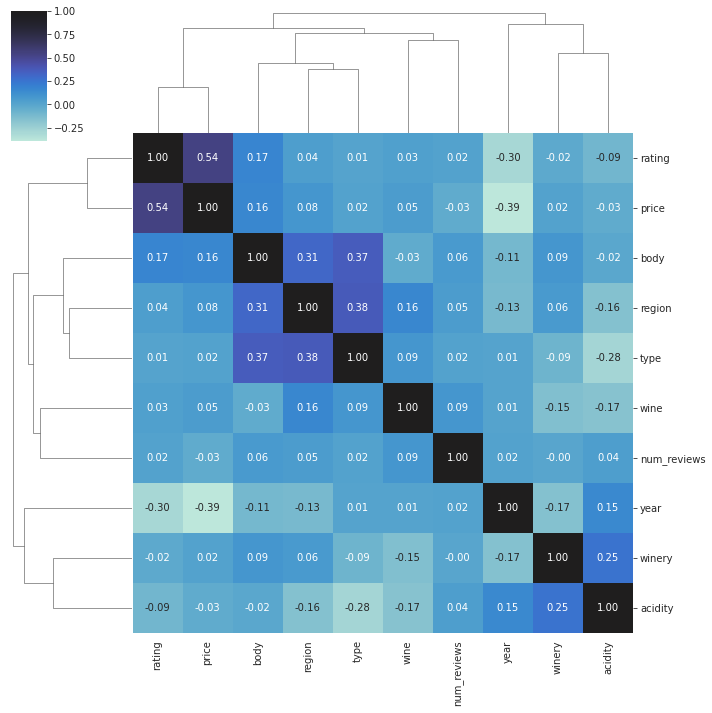

In [11]:
plt.figure(figsize=(12, 6))
sns.clustermap(df.corr(), center=True, annot=True, fmt='.2f');

In [12]:
# 4) acidity nulls
# I will use classification model to predict null values in acidity

X = df.drop('acidity', axis=1)
y = df['acidity'].dropna()

X_train = X.loc[~ df['acidity'].isnull()]
y_train = y[~ df['acidity'].isnull()]
X_test = X.loc[df['acidity'].isnull()]

classifier_filler = RandomForestClassifier(n_estimators=10, bootstrap=True, max_depth=50)
classifier_filler.fit(X_train, y_train)

print(f"Score of the model: {classifier_filler.score(X_train, y_train)}")
try:
    df.loc[df['acidity'].isnull(), 'acidity'] = classifier_filler.predict(X_test)
except ValueError:
    pass

Score of the model: 1.0


In [13]:
print(f'Number of Nulls: {df.isnull().sum().sum()}')

Number of Nulls: 0


<font size=3>Finally, there is no nulls in our dataset anymore 🥳️</font>

### Duplicates

In [14]:
# number of duplicates in dataset
print(f'Number of Duplicates: {df.duplicated().sum()}')

Number of Duplicates: 5468


In [15]:
l = {}
for j in range(4000, 4200):
    val = df.iloc[j].values
    l[j] = []
    for i, row in enumerate(df.values):
        if [*row] == [*val]: l[j].append(i)  
            
df.iloc[l[4002]]

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
2002,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0
2027,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0
2052,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0
2077,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0
2102,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...
7378,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0
7403,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0
7428,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0
7453,152.0,675.0,2011.0,4.2,420,21.0,23.95,10.0,4.0,3.0


> It seems that every data point is repeated almost each **25** row, which explains the reason for all this amount of duplicates.<br>
So, We need to remove all these duplicates

In [16]:
df = df.drop(df[df.duplicated()].index, axis=0)
df.reset_index()
print(f'Number of Duplicates: {df.duplicated().sum()}')

Number of Duplicates: 0


<font size=3>Finally, there is no duplicates in our dataset anymore 🥳️</font>

In [17]:
display(df.head())
print(60*'#', end='\n\n')
display(df.info())

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
0,422.0,759.0,2013.0,4.9,58,69.0,995.00,19.0,5.0,3.0
1,33.0,819.0,2018.0,4.9,31,74.0,313.50,18.0,4.0,2.0
2,447.0,778.0,2009.0,4.8,1793,57.0,324.95,11.0,5.0,3.0
3,447.0,778.0,1999.0,4.8,1705,57.0,692.96,11.0,5.0,3.0
4,447.0,778.0,1996.0,4.8,1309,57.0,778.06,11.0,5.0,3.0


############################################################

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2032 entries, 0 to 6100
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       2032 non-null   float64
 1   wine         2032 non-null   float64
 2   year         2032 non-null   float64
 3   rating       2032 non-null   float64
 4   num_reviews  2032 non-null   int64  
 5   region       2032 non-null   float64
 6   price        2032 non-null   float64
 7   type         2032 non-null   float64
 8   body         2032 non-null   float64
 9   acidity      2032 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 174.6 KB


None

### Outliers

In [18]:
df.describe()

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
count,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,243.866142,468.613189,2011.218112,4.402707,575.326772,51.072835,136.047103,11.081201,4.226378,2.925689
std,147.624265,246.146536,11.032908,0.146509,1381.480469,16.036413,273.090116,3.591911,0.616476,0.321385
min,0.000000,0.000000,1910.000000,4.200000,25.000000,0.000000,4.990000,0.000000,2.000000,1.000000
25%,103.000000,252.000000,2010.000000,4.300000,57.000000,53.000000,32.000000,10.000000,4.000000,3.000000
50%,255.500000,496.000000,2015.000000,4.400000,139.500000,57.000000,53.905000,11.000000,4.000000,3.000000
75%,381.000000,676.000000,2017.000000,4.500000,490.750000,59.000000,110.117500,12.000000,5.000000,3.000000
max,479.000000,846.000000,2021.000000,4.900000,32624.000000,75.000000,3119.080000,20.000000,5.000000,3.000000


#### From describe:
num_reviews, price, body may have outliers

In [19]:
cols = ['num_reviews', 'price', 'body']
px.box(data_frame=df, x='body')
fig = make_subplots(rows=3, cols=1, shared_xaxes=False)

for i, col in zip(range(1, 4), cols):
    fig.add_trace(go.Box(x=df[col], name=col), row=i, col=1)

fig.show()

In [20]:
def drop_outliers_zscore(dfcopy:pd.DataFrame, cols, threshold:int=3, inplace:bool=False):
    '''
    input:  dfcopy            ==> the dataframe that contains outliers
            cols  list / str  ==> list of strings (names of columns that have outliers)
            inplace           ==> if True,  method will edit the original dataframe
                                if False, method will return the new dataframe
            threshold         ==> maximum and minimun threshold of zscore
    
    output: df:        ==>clean dataframe
    this method drops outliers from data using zscore method
    '''
    if inplace:
        global df
    else:
        df = dfcopy.copy()

    def drop_col(df_, col):
        
        mean, std = np.mean(df_[col]), np.std(df_[col])
        df_['is_outlier'] = df_[col].apply(lambda x : np.abs((x - mean) / std) > threshold)
        outliers_idx = df_.loc[df_['is_outlier']].index
        df_ = df_.drop(outliers_idx, axis=0)
        
        df = df_.drop('is_outlier', axis=1)
        return df

    
    if type(cols) == str:
        df = drop_col(df, cols)
    elif type(cols) == list:
        for col in cols:
            df = drop_col(df, col)
    else :
        raise ValueError('Pass neither list nor string in {Cols}')
    
    if inplace:
        dfcopy = df
    else:
        return df
    
THRESHOLD = 4
num_outlier_records =  df.shape[0] - drop_outliers_zscore(df, cols, threshold=THRESHOLD).shape[0]
print(f'Number of Outliers {num_outlier_records}, with threshold, with threshold {THRESHOLD}')

drop_outliers_zscore(df, cols, threshold=THRESHOLD, inplace=True)

Number of Outliers 58, with threshold, with threshold 4


In [21]:
df.shape

(1896, 10)

> Our data is ready to analysis step

### [Return to main ⬆️](#main)

<a id=3></a>
<font color='#681c0b'><h2>EDA</h2>

### Univariate Analysis

In [22]:
l = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1], [3, 0], [3, 1], [4, 0], [4, 1]]
fig = make_subplots(rows=5, cols=2, shared_yaxes=False)

for (i, j), col in zip(l, df):
    fig.add_trace(go.Histogram(x=df[col], histfunc='avg', name=col, nbinsx=20)
                  , row=i+1, col=j+1)

fig.show()

In [23]:
corr = df.corr()
fig = px.imshow(corr, color_continuous_scale='hot',
                zmin=-1, zmax=1,)

fig.update_traces(text=corr.round(2), texttemplate="%{text}")

### Bivariate Analysis

In [24]:
# detect trend_line
def plot_trend_line(df:pd.DataFrame, fig):
    X, y = df[['year']], df[['rating']]
    X.insert(0, 'intercept', 1)

    model = OLS(y, X)
    results = model.fit()
    intercept, coef = results.params.intercept, results.params.year

    X = X.sort_values(by='year')
    y = X['year'] * coef + intercept

    fig.add_shape(type='line',
                  x0=X['year'].iloc[0], y0=y.iloc[0],
                  x1=X['year'].iloc[-1], y1=y.iloc[-1],
                  line=dict(color='red'))

fig = px.line(data_frame=df.groupby('year')['rating'].mean(), title='Rating of Wine from grapped different years')

plot_trend_line(df, fig)


fig.update_layout({'xaxis':{'title':{'text':'Year', 'font':{'color':'blue', 'size':20}}},
                  'yaxis':{'title':{'text':'Rating', 'font':{'color':'blue', 'size':20}}}})

>Insight:<br>
Older Wine is more valuable than recent grapped ones

In [25]:
fig = px.line(data_frame=df.groupby('rating')['num_reviews'].mean(), 
              title='Rating ragarding to number of reviewers', markers=True)

fig['data'][0]['line']['color']="#ff0000"

fig.update_layout({'xaxis':{'title':{'text':'Rating', 'font':{'color':'#ff0000', 'size':20}}},
                   'yaxis':{'title':{'text':'Num_Reviewers', 'font':{'color':'#ff0000', 'size':20}}}}, 
                  hoverlabel=dict(bgcolor='white', font_size=16))

> Insight:<br>
The more people review a wine, the less rating this wine get

In [26]:
rate_num_price = df.groupby('rating')[['num_reviews', 'price']].mean()
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Line(x=rate_num_price.index, y=rate_num_price['num_reviews'], name='line'))


fig.add_trace(go.Scatter(x=rate_num_price.index, y=rate_num_price['num_reviews'], mode='markers', 
                         marker={'size':rate_num_price['price'] / 8}, name='scatter', 
                         hovertemplate = 'Rate: %{x}<br># Reviewers: %{y:}<br>Price: %{marker.size:.2f} $')
              , row=2, col=1)

fig.update_layout(hovermode='closest', hoverlabel=dict(bgcolor="white", font_size=16), 
                  title_text='Price & Num of Reviewers & Rating')

/home/mahmoud/.local/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




>Insight:<br>
>1. Price Increases with wine rating (as expected)
>2.  the gradient of rating is getting decreasing with hight rate wine  

In [27]:
# regions & Rating

region_indices = [*OE.categories_[3]]
region_rate = df.groupby('region')[['rating', 'price']].mean().sort_values(by='rating' ,ascending=False).iloc[:20]
region_rate['rating'] = np.exp(region_rate['rating'])


decoded_idx = [*map(lambda x : region_indices[int(x)], region_rate.index)]
region_rate.index = (decoded_idx)

fig = px.bar(data_frame=region_rate, y=region_rate.index, x='rating', opacity=0.5, orientation='h', 
            title="Top 10 ratings' regions", color='price', color_continuous_scale='rdbu',
            hover_data=['price', 'rating'])

fig.update_yaxes(type='category', categoryorder='total ascending', title='Region', color='#660000')

>Insight:<br>
>1. Most rated wine is bought in Montilla-Morilles.
>2. Dehesa del Carrizal region buy cheap wine with good rating.

### [Return to main ⬆️](#main)

<a id=4></a>
<font color='#681c0b'><h2>Feature Engineering</h2>

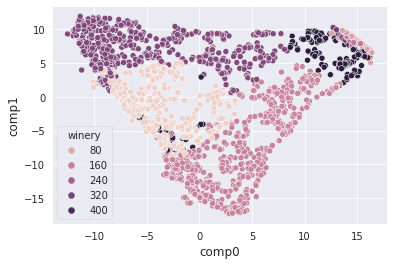

In [28]:
# Cluster based on winery

# 1) drop winery column train clustering model and predict groups 
X = df.drop('winery', axis=1)

# 2) Use TSNE to easy visualize data to check groups 
tsne = TSNE(n_components=3)
Z = tsne.fit_transform(X)

# 3) train clustering model and predict groups 
X = df.drop('winery', axis=1)

model = KMeans(n_clusters=10, init='k-means++')
model.fit(X)
df['winery_g_masks'] = model.predict(X)

# 4) get the winery mode of each group
modes = pd.pivot_table(data=df, index='winery_g_masks',
                       values=['winery'], aggfunc=lambda x : x.mode().iloc[0]).values

df['winery_g'] = df['winery_g_masks'].apply(lambda x : modes[x, 0])

# 5) plot groups 
df_Z = pd.DataFrame({'winery':df['winery_g'], 'comp0':Z[:, 0], 'comp1':Z[:, 1]})
sns.scatterplot(data=df_Z, x='comp0', y='comp1', hue='winery')

# 6) drop groups column (deriven from clustering algorithm)
df.drop('winery_g_masks', axis=1, inplace=True)

From upove graph, I found that winery groups almost are representive for our data.

I am Going to encode **type** columns with One Hot Encoder Instead of ordinal encoder (Not ordinal Feature). 

In [37]:
OHE = OneHotEncoder(drop='first')
types = OHE.fit_transform(df['type'].values.reshape(-1, 1)).toarray()
type_names = ['type_' + str(i) for i in range(df['type'].nunique() - 1)]
types = pd.DataFrame(types, columns=type_names)
df = pd.concat([df, types], axis=1, join='inner')

In [30]:
X = df.drop(['price'], axis=1)
X.insert(0, 'intercept', 1)
y = df.price

model = OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     52.88
Date:                Thu, 18 Aug 2022   Prob (F-statistic):          2.37e-219
Time:                        20:03:17   Log-Likelihood:                -10198.
No. Observations:                1759   AIC:                         2.046e+04
Df Residuals:                    1728   BIC:                         2.063e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    5524.0465    407.190     13.566      

### PCA

In [31]:
cov_matrix = PCA(n_components=df.shape[1])
cov_matrix.fit(X)

fig = px.line(x=range(len(cov_matrix.explained_variance_)), y=cov_matrix.explained_variance_)
fig.add_shape(type='line', y0=1, y1=1, x0=0, x1=30, opacity=0.5, line=dict(color='red', dash='dot'))

From this graph, The best value for Number of Principle Components = **7** PC

In [32]:
pca = PCA(n_components=7)
pca.fit(X)

X = pca.transform(X)

### [Return to main ⬆️](#main)

<a id=5></a>
<font color='#681c0b'><h2>Model Training</h2>

First: **XGboost** 

In [33]:
X = StandardScaler().fit_transform(X)

params = {'booster':['gbtree', 'gblinear', 'dart'], 'n_estimators':range(0, 100, 20)}
xgbmodel = XGBRegressor(max_depth=10)
results = GridSearchCV(xgbmodel, param_grid=params, cv=5).fit(X, y)

[20:03:22] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:03:22] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:03:22] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

In [34]:
params = results.best_params_
xgbmodel = XGBRegressor(max_depth=10, **params)
xgbmodel.fit(X, y)
print(f'Score of xgbmodel: {xgbmodel.score(X, y)}')

y_pred = xgbmodel.predict(X)

print(f'MSE of XGboost model: {mean_squared_error(y, y_pred)}')
print(f'MAE of XGboost model: {mean_absolute_error(y, y_pred)}')

Score of xgbmodel: 0.9998897278686767
MSE of XGboost model: 1.3444941855196957
MAE of XGboost model: 0.735177079297162


Second: **ExtraTree**

In [35]:
extratreeregressor = ExtraTreesRegressor(bootstrap=True, n_estimators=60)
extratreeregressor.fit(X, y)
print(f'Score of ExtraTree model: {extratreeregressor.score(X, y)}')
y_pred = extratreeregressor.predict(X)

print(f'MSE of ExtraTree model: {mean_squared_error(y, y_pred)}')
print(f'MAE of ExtraTree model: {mean_absolute_error(y, y_pred)}')

Score of ExtraTree model: 0.9619089546170054
MSE of ExtraTree model: 464.4254937602301
MAE of ExtraTree model: 13.72906937941345


Third: **Ensemble** Previous two algo

In [36]:
xgb = XGBRegressor(max_depth=10, **params)
etr = ExtraTreesRegressor(bootstrap=True, n_estimators=60)

estimators = [('clf1', xgb), ('clf2', etr)]
voting_model = VotingRegressor(estimators=estimators)
voting_model.fit(X, y)

print(f'Score of Voting model: {voting_model.score(X, y)}')
y_pred = extratreeregressor.predict(X)

print(f'MSE of Voting model: {mean_squared_error(y, y_pred)}')
print(f'MAE of Voting model: {mean_absolute_error(y, y_pred)}')

Score of Voting model: 0.9891735374350589
MSE of Voting model: 464.4254937602301
MAE of Voting model: 13.72906937941345


### [Return to main ⬆️](#main)

Good job for reaching this point, I hope you have enjoyed my notebook ☺️